# import

In [12]:
from __future__ import print_function
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.callbacks import ReduceLROnPlateau, CSVLogger, EarlyStopping

import numpy as np
import resnet
from keras.models import load_model
import glob
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split

# define Paramater

In [40]:
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)
early_stopper = EarlyStopping(min_delta=0.001, patience=10)
csv_logger = CSVLogger('resnet18_cifar10.csv')

batch_size = 8
nb_classes = 2
nb_epoch = 200
data_augmentation = True

# input image dimensions
img_rows, img_cols = 32, 32
# The CIFAR10 images are RGB.
img_channels = 3

# load dataset

## cifar 10

In [33]:
# input image dimensions
img_rows, img_cols = 32, 32
# The CIFAR10 images are RGB.
img_channels = 3

# The data, shuffled and split between train and test sets:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Convert class vectors to binary class matrices.
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# subtract mean and normalize
# mean_image = np.mean(X_train, axis=0)
# X_train -= mean_image
# X_test -= mean_image
# X_train /= 128.
# X_test /= 128.
X_train /= 256.
X_test /= 256.

## original dataset

In [38]:
# フォルダの中にある画像を順次読み込む
# カテゴリーは0から始める

X = []
Y = []

path = 'C:/Users/shihnkawa/Pictures/ダウンロード/'

# 対象Aの画像
for picture in glob.glob(path+'orange/*.???'):
    img = img_to_array(load_img(picture, target_size=(32,32)))
    X.append(img)

    Y.append(0)


# 対象Bの画像
for picture in glob.glob(path+'apple/*.???'):
    img = img_to_array(load_img(picture, target_size=(32,32)))
    X.append(img)

    Y.append(1)


# arrayに変換
X = np.asarray(X)
Y = np.asarray(Y)

# 画素値を0から1の範囲に変換
X = X.astype('float32')
X = X / 255.0

# クラスの形式を変換
Y = np_utils.to_categorical(Y, 2)

# 学習用データとテストデータ
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=111)


C:\ProgramData\Anaconda3\lib\site-packages\PIL\Image.py:953: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


# トレーニング

In [41]:
model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(X_train, Y_train,
              batch_size=batch_size,
              nb_epoch=nb_epoch,
              validation_data=(X_test, Y_test),
              shuffle=True,
              callbacks=[lr_reducer, early_stopper, csv_logger])
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=True,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(X_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size),
                        steps_per_epoch=X_train.shape[0] // batch_size,
                        validation_data=(X_test, Y_test),
                        epochs=nb_epoch, verbose=1, max_q_size=100,
                        shuffle=True,
                        callbacks=[lr_reducer, early_stopper, csv_logger])

Using real-time data augmentation.


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., steps_per_epoch=6, validation_data=(array([[[..., epochs=200, verbose=1, shuffle=True, callbacks=[<keras.ca..., max_queue_size=100)`


Epoch 1/200
6/6 [==============================] - 243s 41s/step - loss: 1.4881 - acc: 0.8542 - val_loss: 9.9133 - val_acc: 0.4231
Epoch 2/200
6/6 [==============================] - 20s 3s/step - loss: 1.2838 - acc: 0.8512 - val_loss: 4.1360 - val_acc: 0.5385
Epoch 3/200
6/6 [==============================] - 36s 6s/step - loss: 0.8463 - acc: 0.9575 - val_loss: 1.9314 - val_acc: 0.7692
Epoch 4/200
6/6 [==============================] - 19s 3s/step - loss: 1.4134 - acc: 0.7653 - val_loss: 1.4620 - val_acc: 0.7692
Epoch 5/200
6/6 [==============================] - 22s 4s/step - loss: 0.9261 - acc: 0.9252 - val_loss: 2.6885 - val_acc: 0.6538
Epoch 6/200
6/6 [==============================] - 19s 3s/step - loss: 0.8949 - acc: 0.8937 - val_loss: 4.7395 - val_acc: 0.4231
Epoch 7/200
6/6 [==============================] - 22s 4s/step - loss: 0.7439 - acc: 0.9787 - val_loss: 4.3341 - val_acc: 0.4231
Epoch 8/200
6/6 [==============================] - 19s 3s/step - loss: 1.1073 - acc: 0.8125 - v

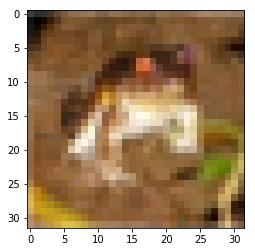

(<matplotlib.image.AxesImage at 0x2693c1de6a0>, None)

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

plt.imshow(X_train[0]),plt.show()

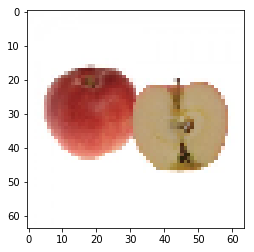

(<matplotlib.image.AxesImage at 0x15be4500ac8>, None)

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(X_train[0]),plt.show()

In [13]:
import numpy as np
def zscore(x, axis = None):
    xmean = x.mean(axis=axis, keepdims=True)
    xstd  = np.std(x, axis=axis, keepdims=True)
    zscore = (x-xmean)/xstd
    return zscore

# subtract mean and normalize
mean_image = np.mean(X_train, axis=0)
X_train -= mean_image
X_test -= mean_image
X_train /= 128.
X_test /= 128.

score = zscore(X_train[0])